Title: Nearest Neighbor Classification
Author: Thomas Breuel
Institution: UniKL

Nearest Neighbor Classification on MNIST Data
=============================================

In [2]:

from pylab import *
from scipy.spatial import distance
import tables
import random as pyrandom

We start off by loading some data. These are images of handwritten digits. This is a fairly typical pattern classification task.



In [3]:
mnist = tables.openFile("mnist.h5","r")

The data is stored in an HDF5 file, an easy way of storing and accessing array data.



In [4]:
mnist

File(filename=mnist.h5, title='', mode='r', rootUEP='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False))
/ (RootGroup) ''
/deskewed (EArray(60000, 28, 28), shuffle, zlib(9)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (20, 28, 28)
/images (CArray(60000, 28, 28), shuffle, zlib(9)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (83, 28, 28)
/labels (CArray(60000,), shuffle, zlib(9)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (16384,)
/test_deskewed (EArray(10000, 28, 28), shuffle, zlib(9)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (20, 28, 28)
/test_images (CArray(10000, 28, 28), shuffle, zlib(9)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  

We can access this on-disk data like arrays in memory.



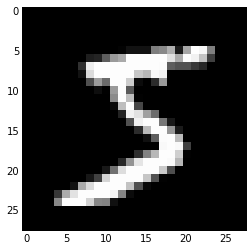

In [5]:
imshow(mnist.root.images[0],cmap=cm.gray,interpolation='nearest')

Access to on-disk data is slower, and it's easier to just copy everything into memory.



In [6]:
images = array(mnist.root.images,'f')
labels = array(mnist.root.labels,'i')

There is a separate _test set_.



In [7]:
test_images = array(mnist.root.test_images,'f')
test_labels = array(mnist.root.test_labels,'i')

Let's look at some more samples.



[5 0 4 1 9 2 1 3 1 4]


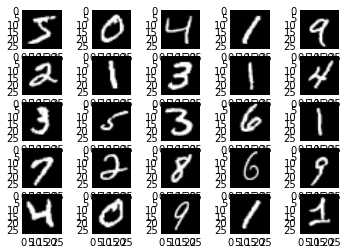

In [8]:
print labels[:10]
for i in range(25):
    subplot(5,5,i+1)
    gray()
    imshow(images[i])

Let's use the first 1000 samples as our training set.



In [9]:
images1k = images[:1000].reshape(1000,28*28)
labels1k = labels[:1000]

Now we define a character recognizer by nearest neighbor classification:

- compute all the distances between the unknown image and the training samples
- return the class associated with the sample at the smallest distance.



In [10]:
def ocr(image):
    ds = distance.cdist(array([image.ravel()]),images1k)
    md = argmin(ds[0])
    return labels1k[md]

(Mathematical Formulation)

If the training set is:

$$ T = \\{(x_1,c_1) ... (x_N,c_N)\\} $$

Mathematically, we write this as:

$$ D(x) = c_{\arg\min_i ||x-x_i||} $$

(Norms and Distances)

Note that we can formulate this in terms of a distance function:

$$ d(x,y) = || x - y || $$

The distance function is here defined in terms of a metric $|| \cdot ||$.

Usually, this is the Euclidean metric:

$$ ||x||^2 = \sum x_i^2 $$

Let's try it out.



In [10]:
ocr(images1k[0])

5

Now let's compute error rates for the test set.



In [11]:
predictions = [ocr(test_images[i]) for i in range(1000)]
print sum(array(predictions)!=array(test_labels[:1000]))/1000.0

0.172


# Test and Training Set Size

Before continuing, let's put our data in a standard form.
Usually, we represent data sets as a large 2D array, where the rows correspond to a sample.

Since our original data is rank 3 (or maybe higher rank), we need to reshape.



In [11]:
def make2d(a):
    return a.reshape(len(a),prod(a.shape[1:]))

This wraps up nearest neighbor evaluation; all you do is give it a training set and a test set, and it returns the resulting error rate.



In [12]:
def nneval(training,ltraining,testing,ltesting,**kw):
    ds = distance.cdist(make2d(testing),make2d(training),**kw)
    closest = argmin(ds,axis=1)
    predictions = [ltraining[i] for i in closest]
    errors = sum(array(predictions)!=array(ltesting))
    return errors*1.0/len(testing)

Here is the nearest neighbor experiment we just ran.



In [14]:
nneval(images[:1000],labels[:1000],test_images[:1000],test_labels[:1000])

0.17199999999999999

Note that it is important that we use different test and training sets, otherwise we get incorrect estimates of performance. This is particularly pronounced with nearest neighbor classifiers (why?), but also happens with other classifiers.



In [15]:
nneval(images[:1000],labels[:1000],images[:1000],labels[:1000])

0.0

# Margin of Error

Let's try different randomly chosen test sets. Note that we don't get the same error estimate every time.



In [16]:
errs = []
for i in range(10):
    S = array(pyrandom.sample(xrange(len(test_images)),1000),'i')
    e = nneval(images[:1000],labels[:1000],test_images[S],test_labels[S])
    print e
    errs.append(e)
print "mean",mean(errs)
print "sd",var(errs)**.5

0.147
0.143
0.124
0.154
0.147
0.128
0.115
0.135
0.144
0.129
mean 0.1366
sd 0.0117234807118


(Binomial Distributions)

Each of these estimates of the error rate is a random sample.
This is similar to presidential polling.

We're taking $n$ samples, and each sample is randomly true or false with the probability of error $p$.
It is determined by a binomial distribution.

The variance of a binomial distribution with probability $p$ and sample size $n$ is:

$$ v = n p (1-p) $$

We want to know the variance of the estimate of $p$, which is:

$$ \hat{p} = \frac{k}{n} $$

$$ \sigma_{\hat{p}} = \sqrt{\frac{v}{n^2}} = \sqrt{\frac{p(1-p)}{n}} $$

(Margin of Error)

We want to have a high confidence that our estimate of the probability of error is close to the true error rate. If we want that confidence to be 95 percent, then we need to choose a margin of error of $\pm 2\sigma$.

Note that the standard deviation we calculate from the error rate is pretty close to the one we actually observe.




In [66]:
sd = ((0.1*(1-0.1))/1000.0)**.5
print sd

0.00948683298051


(Comparing Classifiers)

Often we want to be able to say: "classifer 1 is better than classifier 2 because it gets a lower error rate".

When making such comparisons, it is essential to take into account the _margin of error_.

If the error rate estimates of two classifiers are within the margin of error within each other, we cannot reliably determine which classifier is "better".

In that case, we need more training/test data.

(Publications)

You *must* give the margin of error for any classifier error rate estimates in your reports / publications.

In simple cases, it is sufficient to give the number of samples used for evaluation.

In complex cases, you may want to use other kinds of _significance tests_.

# Preprocessing and Feature Extraction

Classifier performance can often be improved with preprocessing and feature extraction.
This can be as simple as blurring.



In [16]:
from scipy.ndimage import filters
def f(x):
    return filters.gaussian_filter(x,1.0)

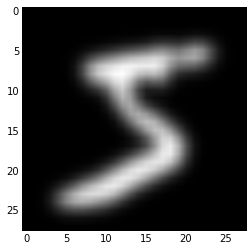

In [20]:
gray(); imshow(f(images[0]))

Note the improved performance relative to the original classifier.



In [21]:
nneval(amap(f,images[:1000]),labels[:1000],amap(f,test_images),test_labels)

0.114

It's useful to try different parameters for feature extractors. Note that we evaluate using the saem test set; this generally helps reduce the variance of our error estimates greatly.



In [22]:
for sigma in [0.0,0.5,1.0,2.0,3.0]:
    def f(x):
        return filters.gaussian_filter(x,sigma)
    print sigma,nneval(amap(f,images[:1000]),labels[:1000],amap(f,test_images),test_labels)

0.0 0.131
0.5 0.1234
1.0 0.114
2.0 0.1506
3.0 0.2256


You can experiment with other preprocessing methods.



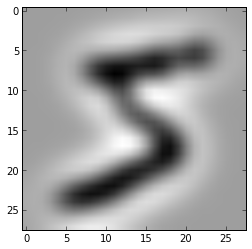

In [23]:
imshow(filters.gaussian_laplace(images[0],2.0))

Again, you need to evaluate your preprocessing.



In [24]:
for sigma in [0.5,1.0,2.0,3.0,4.0]:
    def f(x):
        return filters.gaussian_laplace(x,sigma)
    print sigma,nneval(amap(f,images[:1000]),labels[:1000],amap(f,test_images),test_labels)

0.5 0.256
1.0 0.2013
2.0 0.1123
3.0 0.1235
4.0 0.171


A common feature extraction method is gradient filtering. This is motivated by biological vision systems, but also has some theoretical justifications.



In [25]:
from scipy.ndimage import interpolation
def gf(x,sigma=1.0,power=1,zoom=1):
    d0 = filters.gaussian_filter(x,sigma,order=(1,0))
    d1 = filters.gaussian_filter(x,sigma,order=(0,1))
    if power!=1:
        d0 = d0**power
        d1 = d1**power
    result = hstack([d0,d1])
    if zoom!=1:
        result = interpolation.zoom(result,zoom)
    return result

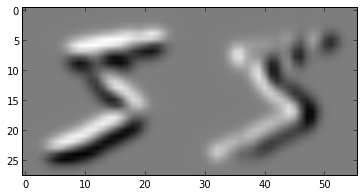

In [26]:
imshow(gf(images[0]))

Note that we are getting slightly better performance than with blurring.



In [27]:
for sigma in [0.5,1.0,1.5,2.0,2.5,3.0,4.0]:
    def f(x):
        return gf(x,sigma=sigma)
    print sigma,nneval(amap(f,images[:1000]),labels[:1000],amap(f,test_images),test_labels)

0.5 0.1817
1.0 0.1349
1.5 0.1078
2.0 0.1088
2.5 0.1241
3.0 0.1496
4.0 0.216


Normalization and Metrics
==========================

(Nearest Neighbor Classification)

If the training set is:

$$ T = \\{(x_1,c_1) ... (x_N,c_N)\\} $$

Mathematically, we write this as:

$$ D(x) = c_\{\arg\min_i ||x-x_i||\} $$

Here, we used a _norm_, written as the function $||\cdot ||$.

(Norms)

There are many different kinds of norms:

$$ || x ||_2 = \left( \sum x_i^2 \right) ^ {1/2} $$

$$ || x ||_1 = \left( \sum |x_i| \right) $$

$$ || x ||_d = \left( \sum |x_i|^d \right)^ {1/d} $$

$$ || x ||_\infty = \max |x_i| = \lim_{d\rightarrow\infty} ||x||_d $$

(Norm Axioms)

A norm captures the idea of a _length_ of a vector. It must satisfy:

$$ ||\cdot|| : {\mathbb R}^n \rightarrow {\mathbb R} $$
$$ ||x||>0 \hbox{ if } x\neq 0 $$
$$ ||\alpha x|| = |\alpha|\,||x|| $$

Triangle inequality:
$$ ||x + y|| \leq ||x|| + ||y|| $$

(Metrics)

A _metric_ is a way of measuring _distance_ in a space. In vector spaces, it is closely related to norms.

$$ d(x,y) = ||x - y|| $$

Abstractly, norms are required to have the following properties:

$$d(x,y)\geq 0$$
$$d(x,y)=0 \hbox{ iff } x=y$$
$$d(x,y) = d(y,x) \hbox{ (symmetry)}$$
$$d(x,z) \leq d(x,y) + d(y,z) \hbox{ (triangle inequality)}$$

(Similarity / Dissimilarity Functions)

There is no strict requirement that we use norms or metrics for "nearest neighbor" classification.

Often, we can use dissimilarity functions. Generally, we prefer dissimilarity functions that satisfy:

$$d(x,y)\geq 0$$
$$d(x,y)=0 \hbox{ iff } x=y$$
$$d(x,y) = d(y,x) \hbox{ (symmetry)}$$

However, none of those are necessary for good performance of a nearest neighbor classifier.

For a _dissimilarity function_, generally, the value of the function should increase with increasing dissimilarity.

In [18]:
for p in [1,2,3,4]:
    def f(x):
        v = filters.gaussian_filter(x,sigma=1.5)
        return v
    print p,nneval(amap(f,images[:1000]),labels[:1000],amap(f,test_images[:1000]),test_labels[:1000],metric='minkowski',p=p)

 1 0.159
2 0.147
3 0.143
4 0.152


(Normalization)

A second important concept is that of _normalization_.
Often, an input vector is known only up to a scale factor.

That is, $x$ and $\alpha x$ really represent the same sample.

We can remove this influence by transforming the data as in

$$ x \rightarrow \frac{x}{||x||} $$

Note that any norm will do, but they will yield different results for classification.

In [29]:
for sigma in [0.5,1.0,2.0,3.0,4.0]:
    def f(x):
        v = gf(x,sigma=sigma)
        v = v*1.0/norm(v.ravel())
        return v
    print sigma,nneval(amap(f,images[:1000]),labels[:1000],amap(f,test_images),test_labels)

0.5 0.1517
1.0 0.1187
2.0 0.0921
3.0 0.1276
4.0 0.1734


An analogous way of computing this is to use the _consine dissimilarity_:

$$ d(x,y) = 1 - \frac{x \cdot y}{||x|| ~ ||y||} $$

In [47]:
# cosine dissimilarity
for sigma in [0.5,1.0,2.0,3.0,4.0]:
    def f(x):
        v = gf(x,sigma=sigma)
        v = v*1.0/norm(v.ravel())
        return v
    print sigma,nneval(amap(f,images[:1000]),labels[:1000],
                       amap(f,test_images),test_labels,
                       metric='cosine')

0.5 0.1517
1.0 0.1187
2.0 0.0921
3.0 0.1276
4.0 0.1734


(Note)

Note that a combination of normalization and feature extraction gives us the best recognition performance so far.

You need to experiment to find good combinations.

The best preprocessing for one classifier isn't necessarily the best preprocessing for another classifier.

Deskewing and Canonicalization
==============================

There are other kinds of preprocessing that we can perform that greatly improve recognition.

Generally, these are aimed at making recognition _invariant_ under transformation.

We've already seen a couple of examples of this:

$$ x\rightarrow \alpha x ~~\hbox{ canonicalize by }~~ x \rightarrow \frac{x}{|| x ||} $$

$$ x\rightarrow x + c ~~\hbox{ canonicalize by }~~ x \rightarrow x - \bar{x} $$

(Canonical Elements)

Formally, we say that the set of all feature vectors is divided into subsets, where each subset contains vectors that are equivalent from the point of view of recognition.

For each subset, we pick a _canonical element_ via a canonicalization function.

So, assume that some $x_r$ has class $c_r$.

Then $S_r = \\{x | x = x_r + \alpha \\}$ all is in the same class as $c_r$.

The canonical element is found by the function:

$$ f(x) = x - \bar{x} $$

$$ S_r = \\{ x | f(x) = f(x_r) \\} $$

Note that this does not work perfectly in the presence of errors.

(Invariants)

Classification is about decision functions $D(x)$

A decision function is _invariant_ under a transformation $f$ if $D(f(x)) = D(x)$ for all $x$.

A decision function is _invariant_ under a group transformation $G$ if $D(g(x)) = D(x)$ for all $x$ and for all $g\in G$.

The set of $ \\{ g\cdot x | g \in G \\} $ is often a set of equivalent samples and we can pick a canonical element by computing an appropriate transformation $g(x)$ and then using $g(x)\cdot x$ as a canonical element.

(Translations)

Assume that classes are invariant under _shifts_ or _translations_ of the input image.

We can use the _centroid_ as a canonicalizer.

This is like considering the input image as a point cloud and computing the "average point".

In [20]:
def centroid(image):
    c0,c1 = mgrid[:image.shape[0],:image.shape[1]]
    xm = sum(c0*image)/sum(image)
    ym = sum(c1*image)/sum(image)
    return xm,ym

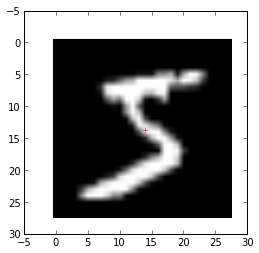

In [23]:
y,x = centroid(images[0])
imshow(images[0])
plot([y],[x],'r+')

The MNIST data has already been normalized so that the centroid is approximately at the center of the image (but it can't hurt to check).



In [25]:
for i in range(10):
    print centroid(images[i])

(14.035783690482875, 13.645193370657632)
(13.553301030232202, 14.097568454157251)
(14.103585733921463, 13.543178344551675)
(14.487537587239133, 13.993461209772029)
(14.079522362948207, 13.71181319082735)
(14.074792275054866, 14.018848223932769)
(13.908193650058521, 14.408703656101897)
(13.945435392218119, 14.323666012968628)
(14.336858182082644, 14.11541252284602)
(13.822177247288515, 14.459001526253239)


The MNIST data hasn't been _skew corrected_. That is, characters may be slanted and/or rotated.

To find this, we compute the major and minor axes of the covariance matrix (the second moments).



In [26]:
def moments(image):
    c0,c1 = mgrid[:image.shape[0],:image.shape[1]]
    m0 = sum(c0*image)/sum(image)
    m1 = sum(c1*image)/sum(image)
    m00 = sum((c0-m0)**2*image)/sum(image)
    m11 = sum((c1-m1)**2*image)/sum(image)
    m01 = sum((c0-m0)*(c1-m1)*image)/sum(image)
    return array([m0,m1]),array([[m00,m01],[m01,m11]])

In [27]:
c,v = moments(images[0])
print c

[ 14.03578369  13.64519337]


In [29]:
l,evs = eig(v)
print l
print evs

[ 45.88981162  12.77832657]
[[ 0.9490232   0.31520622]
 [-0.31520622  0.9490232 ]]


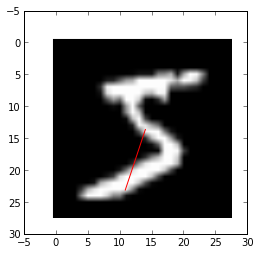

In [33]:
y,x = c
((e00,e01),(e10,e11)) = evs
imshow(images[0])
plot([y,y+10*e10],[x,x+10*e11],'r')

Now we want to rotate or deskew the character. For rotation, we make this vector vertical.



In [35]:

from scipy.ndimage import interpolation

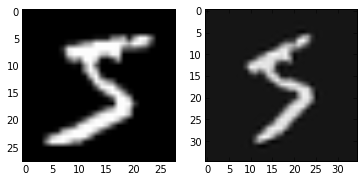

In [36]:
subplot(121); imshow(images[0])
angle = arctan2(evs[0][1],evs[0][0])*180/pi
subplot(122); imshow(interpolation.rotate(images[0],angle))

In [62]:
# computing a rotation angle for each image
def rotation_angle(image):
    c,v = moments(image)
    l,evs = eig(v)
    i = argmax(l)
    angle = arctan2(evs[i][1],evs[i][0])*180/pi
    return angle
def derotate(image):
    return interpolation.rotate(image,rotation_angle(image),reshape=0,order=1)

Result of canonicalizing by rotation.



[5 0 4 1 9 2 1 3 1 4]


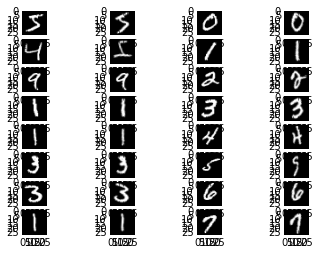

In [63]:
print labels[:10]
for i in range(16):
    subplot(8,4,2*i+1)
    gray()
    imshow(images[i])
    subplot(8,4,2*i+2)
    imshow(derotate(images[i]))

It turns out that canonicalizing by rotation isn't the best thing to do. It's generally better to _deskew_.
Skewing is a coordinate tranformation of the form:

$$ M = \left(\begin{array}{cc} 1 & 0 \\\ \alpha & 1 \end{array} \right) $$

This is also called a _shear_ transformation. The further a pixel is removed from $y=0$, the further its $x$ coordinate is shifted.

In [46]:
# deskew transformation
def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = array([[1,0],[alpha,1]])
    ocenter = array(image.shape)/2.0
    offset = c-dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset,order=1)

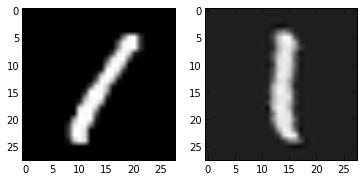

In [47]:
subplot(121); imshow(images[3])
subplot(122); imshow(deskew(images[3]))

[5 0 4 1 9 2 1 3 1 4]


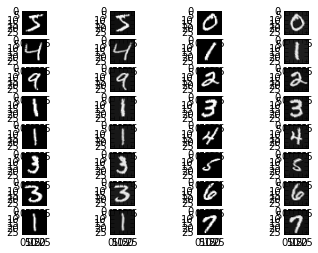

In [49]:
# effect of deskewing
print labels[:10]
for i in range(16):
    subplot(8,4,2*i+1)
    gray()
    imshow(images[i])
    subplot(8,4,2*i+2)
    imshow(deskew(images[i]))

Let's now look at the error rates achieved with deskewing:


In [65]:
print "derotated",nneval(amap(derotate,images[:1000]),labels[:1000],amap(derotate,test_images),test_labels)
print "deskewed",nneval(amap(deskew,images[:1000]),labels[:1000],amap(deskew,test_images),test_labels)
print "original",nneval(images[:1000],labels[:1000],test_images,test_labels)



derotated 0.1308
deskewed 0.0761
original 0.131


Not that deskewing results in substantial improvements, while derotating hardly gives an improvement at all.

(We could analyze this further with confusion matrices, and there may be ways of fixing this.)